In [4]:
source("./libs.R")

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 772 rows [3, 50, 83, 84, 138, 181, 196, 213, 253, 265, 274, 301, 303, 353, 371, 388, 412, 434, 491, 495, ...].”

## data load

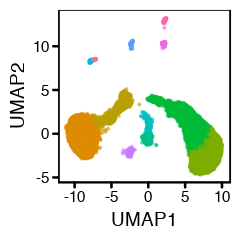

In [5]:
options(repr.plot.width = 2, repr.plot.height = 2)

ggplot(input.umap.res, aes(UMAP1, UMAP2)) + geom_point(aes(color = cluster), size = 0.1, 
    alpha = 0.5) + theme_pubr() + theme(legend.position = "none")

In [7]:
table(input.umap.res %>% filter(barcodes %in% colnames(input.chromVar.jaspar.z)[-1]) %>% 
    pull(cell_type_overall))
table(input.umap.res %>% pull(cell_type_overall))
table(input.umap.res %>% pull(cell_type_overall))%>%as.numeric%>%sum


     acinar       alpha        beta       delta      ductal endothelial 
         46        6217        7598         710          80         118 
      gamma      immune    stellate 
        260         140         128 


     acinar       alpha        beta       delta      ductal endothelial 
         46        6218        7598         710          80         118 
      gamma      immune    stellate 
        260         140         128 

[1] 15298

In [8]:
input.chromVar.jaspar.z.agg <- melt(data.table(assays(input.chromVar.res.list$dev)$z, 
    keep.rownames = T), id = "rn", variable.name = "barcodes", value.name = "zval")
input.chromVar.jaspar.z.agg %>% head(1)

input.chromVar.jaspar.z.agg %>% nrow
input.chromVar.jaspar.z.agg <- input.chromVar.jaspar.z.agg %>% inner_join(input.umap.res) %>% 
    separate(rn, into = c("id", "name"), sep = "_")
input.chromVar.jaspar.z.agg %>% nrow

input.chromVar.jaspar.z.agg %>% head(1)
input.chromVar.jaspar.z.agg %>% select(barcodes, cell_type_overall) %>% unique %>% 
    pull(cell_type_overall) %>% table

range(input.chromVar.jaspar.z.agg$zval, na.rm = T)
input.chromVar.jaspar.z.agg$zval[is.na(input.chromVar.jaspar.z.agg$zval)] <- 0
range(input.chromVar.jaspar.z.agg$zval, na.rm = T)

rn,barcodes,zval
MA0004.1_Arnt,Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,-1.566904


[1] 8857542

Joining, by = "barcodes"
Warning message:
“Column `barcodes` joining factor and character vector, coercing into character vector”

[1] 8857542

id,name,barcodes,zval,UMAP1,UMAP2,cluster,cell_type_overall,subtype,unique_usable_reads,log_usable_counts,frac_duplicated_reads,frac_mito_reads,frac_promoters_used,frac_reads_in_peaks,frac_reads_in_promoters
MA0004.1,Arnt,Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,-1.566904,-5.102393,1.38682,alpha_2,alpha,2,6254,7.865955,0.7902986,0.03428042,0.04337516,0.5978574,0.2646306


.
     acinar       alpha        beta       delta      ductal endothelial 
         46        6218        7598         710          80         118 
      gamma      immune    stellate 
        260         140         128 

[1] -20.16193  31.35658

[1] -20.16193  31.35658

In [16]:
ttest.res <- fread("../figures/Fig2/subfigs/fig2D_sub_vs_sub.csv") %>% mutate(lfdr = ifelse(enrichedIn %in% 
    c("alpha_1", "beta_1", "delta_1"), log10(FDR), -log10(FDR))) %>% arrange(enrichedIn, 
    lfdr, desc(mean_x - mean_y))
ttest.res %>% head(1)
dim(ttest.res)
ttest.res %>% select(motif, test) %>% unique %>% nrow

motif,jaspar.id,x,y,test,mean_x,mean_y,enrichedIn,pval,FDR,padj,family.id,family.name,class.id,class.name,superclass.id,superclass.name,lfdr
NEUROD1,MA1109.1,alpha_1,alpha_2,alpha_1.vs.alpha_2,0.1334647,-1.673909,alpha_1,9.501045e-240,2.200442e-238,5.501105e-237,1.2.3,Tal-related,1.2,Basic helix-loop-helix factors (bHLH),1,Basic domains,-237.6575


[1] 1842   18

[1] 1737

## UMAPs

In [65]:
input.chromVar.jaspar.z.agg%>%head(1)

id,name,barcodes,zval,UMAP1,UMAP2,cluster,cell_type_overall,subtype,unique_usable_reads,log_usable_counts,frac_duplicated_reads,frac_mito_reads,frac_promoters_used,frac_reads_in_peaks,frac_reads_in_promoters
MA0004.1,Arnt,Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,-1.566904,-5.102393,1.38682,alpha_2,alpha,2,6254,7.865955,0.7902986,0.03428042,0.04337516,0.5978574,0.2646306


Joining, by = "barcodes"
Joining, by = "barcodes"


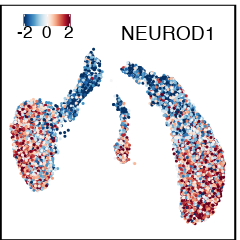

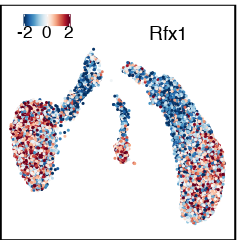

In [69]:
options(repr.plot.width = 2, repr.plot.height = 2)
saveUmap <- function(p, m, prefix) {
    fn <- paste0(prefix, m, ".umap.pdf")
    ggsave(fn, p, width = 2, height = 2, units = "in", useDingbats = F)
    system(paste0("open ", fn))
    fwrite(p$data %>% select(UMAP1, UMAP2, zval, cluster), sub("pdf", "csv", fn))
    system(paste0("open ", sub("pdf", "csv", fn)))
}
plot.umap.motif <- function(m, bks_ = c(-2, 0, 2), pref = "../figures/Fig2/subfigs/fig2_state1_motifs.") {
    p = fun.plot.project.motif(m, legend.pos = c(0.2, 0.9), bks = bks_, size = 0.25, 
        cls = rev(brewer.pal(n = 11, "RdBu")))
    p$data <- p$data %>% filter(cell_type_overall %in% c("alpha", "beta", "delta"))
    p <- p + annotate(geom = "text", x = 4.5, y = 6, label = m) + coord_cartesian(ylim = c(-5, 
        7))
    print(p)
    saveUmap(p, m, pref)
}
plot.umap.motif("NEUROD1")
plot.umap.motif("Rfx1")

Joining, by = "barcodes"
Joining, by = "barcodes"


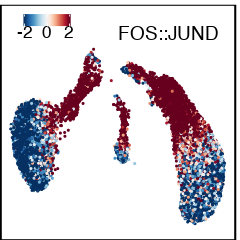

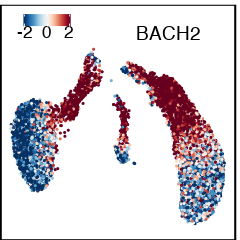

In [70]:
plot.umap.motif("FOS::JUND", pref = "../figures/Fig2/subfigs/fig2_state2_motifs.")
plot.umap.motif("BACH2", pref = "../figures/Fig2/subfigs/fig2_state2_motifs.")

## Rank plot

[1] 579
    motif       x       y               test    mean_x    mean_y enrichedIn
1 NEUROD1 alpha_1 alpha_2 alpha_1.vs.alpha_2 0.1334647 -1.673909    alpha_1
           pval           FDR          padj      lfdr
1 9.501045e-240 2.200442e-238 5.501105e-237 -237.6575
[1] 2.022346      Inf
[1]   2.022346 307.952874


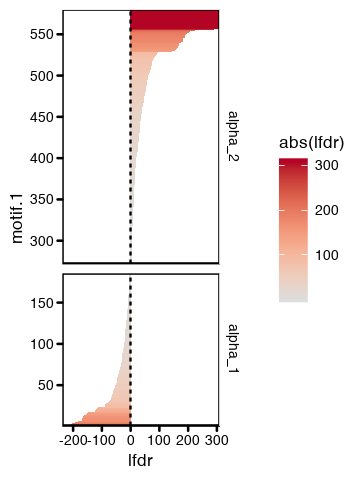

In [39]:
options(repr.plot.width = 3, repr.plot.height = 4)
plotRankMotif <- function(res = ttest.res, test_nm = "alpha_1.vs.alpha_2", sep = ".vs.") {
    require(pals)
    test_items <- strsplit(test_nm, sep) %>% unlist %>% rev
    
    pd.rank <- res %>% select(-contains(".")) %>% unique %>% filter(test == test_nm) %>% 
        ungroup
    nmotifs <- pd.rank %>% nrow %>% print
    pd.rank %>% head(1) %>% print
    n_m = 0
    
    pd.rank <- pd.rank %>% mutate(motif.1 = as.numeric(factor(motif, levels = pd.rank$motif)) - 
        n_m) %>% filter(FDR < 0.01) %>% mutate(enrichedIn = factor(enrichedIn, levels = test_items))
    pd.rank %>% pull(lfdr) %>% abs %>% range %>% print
    
    ## handle Inf and - Inf
    (upper <- pd.rank %>% filter(lfdr > 0 & !is.infinite(lfdr)) %>% pull(lfdr) %>% 
        max)
    (lower <- pd.rank %>% filter(lfdr < 0 & !is.infinite(lfdr)) %>% pull(lfdr) %>% 
        min)
    
    pd.rank <- pd.rank %>% mutate(lfdr = ifelse(lfdr > 0 & is.infinite(lfdr), upper, 
        ifelse(lfdr < 0 & is.infinite(lfdr), lower, lfdr)))
    
    pd.rank %>% pull(lfdr) %>% abs %>% range %>% print
    
    ## plot
    ggplot(pd.rank) + geom_bar(aes(motif.1, lfdr, fill = abs(lfdr)), stat = "identity") + 
        theme_pubr(base_size = 10) + theme() + coord_flip(expand = F) + scale_fill_gradientn(colours = pal.compress(coolwarm)[7:13]) + 
        scale_x_continuous(breaks = seq(0 - n_m, nmotifs - n_m, 50)) + facet_grid(enrichedIn ~ 
        ., scales = "free_y", space = "free_y") + geom_hline(yintercept = 0, linetype = 2)
}

p <- plotRankMotif()
print(p)


ggsave(paste0("../figures/Fig2/subfigs/fig2_sub_vs_sub.alpha.rankedBar.pdf"), width = 3, 
    height = 4, units = "in", useDingbats = F)
system(paste0("open ../figures/Fig2/subfigs/fig2_sub_vs_sub.alpha.rankedBar.pdf"))
fwrite(p$data %>% select(motif, motif.1, lfdr, enrichedIn), "../figures/Fig2/subfigs/fig2_sub_vs_sub.alpha.rankedBar.csv")
system("open ../figures/Fig2/subfigs/fig2_sub_vs_sub.alpha.rankedBar.csv")

[1] 579
    motif      x      y             test    mean_x     mean_y enrichedIn pval
1 NEUROD1 beta_1 beta_2 beta_1.vs.beta_2 0.8256822 -0.5042033     beta_1    0
  FDR padj lfdr
1   0    0 -Inf
[1] 2.049746      Inf
[1]   2.049746 292.062652


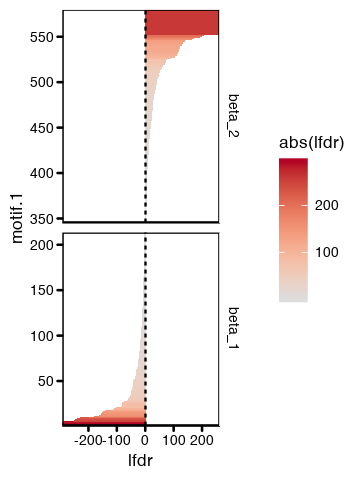

In [40]:
p <- plotRankMotif(test_nm = "beta_1.vs.beta_2")
print(p)

ggsave(paste0("../figures/Fig2/subfigs/fig2_sub_vs_sub.beta.rankedBar.pdf"), width = 3, 
    height = 4, units = "in", useDingbats = F)
system(paste0("open ../figures/Fig2/subfigs/fig2_sub_vs_sub.beta.rankedBar.pdf"))
fwrite(p$data %>% select(motif, motif.1, lfdr, enrichedIn), "../figures/Fig2/subfigs/fig2_sub_vs_sub.beta.rankedBar.csv")
system("open ../figures/Fig2/subfigs/fig2_sub_vs_sub.beta.rankedBar.csv")

[1] 579
  motif       x       y               test    mean_x    mean_y enrichedIn
1  Rfx1 delta_1 delta_2 delta_1.vs.delta_2 0.7560459 -1.238505    delta_1
          pval         FDR         padj     lfdr
1 4.338732e-56 1.00485e-54 2.512126e-53 -53.9979
[1]  2.009251 73.503123
[1]  2.009251 73.503123


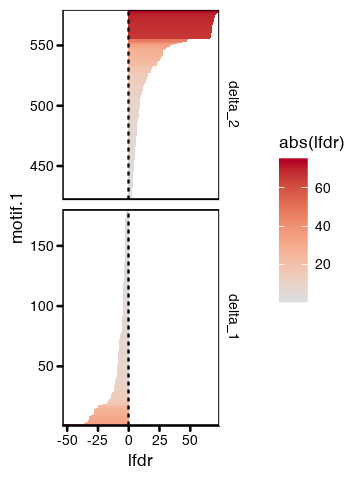

In [41]:
p <- plotRankMotif(test_nm = "delta_1.vs.delta_2")
print(p)

ggsave(paste0("../figures/Fig2/subfigs/fig2_sub_vs_sub.delta.rankedBar.pdf"), width = 3, 
    height = 4, units = "in", useDingbats = F)
system(paste0("open ../figures/Fig2/subfigs/fig2_sub_vs_sub.delta.rankedBar.pdf"))
fwrite(p$data %>% select(motif, motif.1, lfdr, enrichedIn), "../figures/Fig2/subfigs/fig2_sub_vs_sub.delta.rankedBar.csv")
system("open ../figures/Fig2/subfigs/fig2_sub_vs_sub.delta.rankedBar.csv")

## UMAP + violin

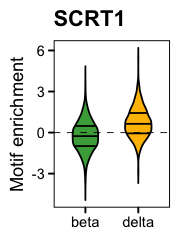

In [56]:
plotViolin <- function(motif = m, test_celltypes = celltype.test) {
    pd <- input.chromVar.jaspar.z.agg %>% filter(name == motif, cell_type_overall %in% 
        test_celltypes)
    pd$cell_type_overall <- factor(pd$cell_type_overall,levels = test_celltypes)
    ggviolin(pd, x = "cell_type_overall", remove = T, width = 0.5, y = "zval", size = 0.5, 
        shape = 16, draw_quantiles = c(0.25, 0.5, 0.75), fill = "cell_type_overall", 
        ylab = "Motif enrichment") + theme_pubr() + ggtitle(motif) + geom_hline(yintercept = 0, 
        linetype = 2, size = 0.25) + theme(legend.position = "none", axis.title.x = element_blank()) + scale_fill_manual(values = cols.celltype)
    
}# axis.text.x = element_text(angle = 45, hjust = 1)
options(repr.plot.width = 1.5, repr.plot.height = 2)
plotViolin("SCRT1", c("beta", "delta"))

Joining, by = "index"


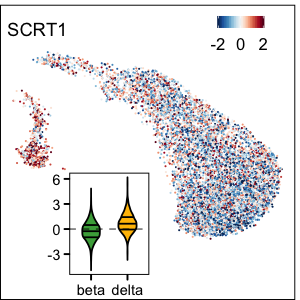

In [72]:
plotMotif_bd <- function(m = "TCF7L2") {
    options(repr.plot.width = 2.5, repr.plot.height = 2.5)
    
    p <- fun.plot.project.motif(motif = m, bks = c(-2, 0, 2), size = 0.25, cls = rev(brewer.pal(n = 11, 
        "RdBu")))
    p$data <- p$data %>% filter(cell_type_overall %in% c("beta", "delta"))
    p2 <- plotViolin(m, c("beta", "delta"))
    
    print(p + coord_cartesian(ylim = c(-7, 6)) + annotate(geom = "text", x = 0, y = 5.5, 
        label = m) + annotation_custom((p2 + theme(title = element_blank())) %>% 
        ggplotGrob, 0, 5, -8, -1))
    
    ggsave(paste0("~/Dropbox (UCSD_Epigenomics)/workReports/2019-10_islet_rev/Fig1.rev.candid/Fig1.rev.candid.", 
        m, ".b_d.umap.pdf"), width = 2.5, height = 2.5, units = "in", useDingbats = F)
}
plotMotif_bd("SCRT1")

rank,motif,mean_x,mean_y,pval,test,x,y,enrichedIn,FDR,padj,diff,id
<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
187,NRL,-0.09615801,-1.187419,2.32e-89,beta_vs_delta,beta,delta,beta,8.9552e-87,8.9552e-87,1.091261,MA0842.1


[1]  2.00891 86.04792

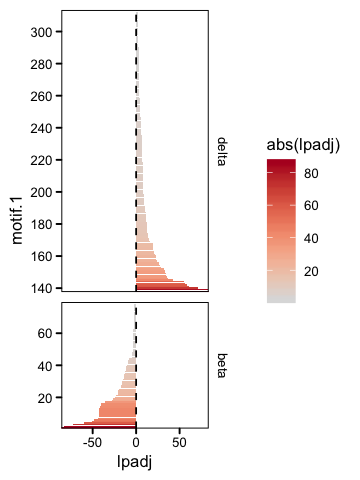

In [57]:
options(repr.plot.width = 3, repr.plot.height = 4)
require(pals)

pd.rank <- ttest.res %>% select(-contains(".")) %>% unique %>% filter(test == "beta_vs_delta") %>% 
    ungroup

head(pd.rank, 1)
n_m = nrow(pd.rank %>% filter(enrichedIn == "delta"))
n_m = 0
pd.rank <- pd.rank %>% mutate(motif.1 = as.numeric(factor(motif, levels = pd.rank$motif)) - 
    n_m, lpadj = ifelse(enrichedIn == "beta", log10(FDR), -log10(FDR))) %>% filter(FDR < 
    0.01) %>% mutate(enrichedIn = factor(enrichedIn, levels = c("delta", "beta")))
pd.rank%>%pull(lpadj)%>%abs%>%range
ggplot(pd.rank) + geom_bar(aes(motif.1, lpadj, fill = abs(lpadj)), stat = "identity") + 
    theme_pubr(base_size = 10) + theme() + coord_flip(expand = F) + scale_fill_gradientn(colours = pal.compress(coolwarm)[7:13]) + 
    scale_x_continuous(breaks = seq(0 - n_m, 386 - n_m, 20)) + facet_grid(enrichedIn ~ 
    ., scales = "free_y", space = "free_y") + geom_hline(yintercept = 0, linetype = 2)

rank,motif,mean_x,mean_y,pval,test,x,y,enrichedIn,FDR,padj,diff,id
<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,MAFG,0.4259281,-2.01688,1.42e-74,alpha_vs_gamma,alpha,gamma,alpha,5.4812e-72,5.4812e-72,2.442808,MA0659.1


[1]  2.064016 71.261124

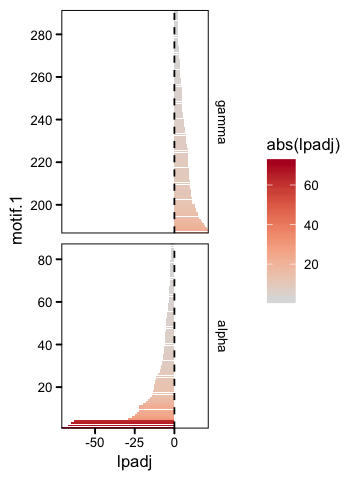

In [59]:
options(repr.plot.width = 3, repr.plot.height = 4)
require(pals)

pd.rank <- ttest.res %>% select(-contains(".")) %>% unique %>% filter(test == "alpha_vs_gamma") %>% 
    ungroup

head(pd.rank, 1)
n_m = nrow(pd.rank %>% filter(enrichedIn == "gamma"))
n_m = 0
pd.rank <- pd.rank %>% mutate(motif.1 = as.numeric(factor(motif, levels = pd.rank$motif)) - 
    n_m, lpadj = ifelse(enrichedIn == "alpha", log10(FDR), -log10(FDR))) %>% filter(FDR < 
    0.01) %>% mutate(enrichedIn = factor(enrichedIn, levels = c("gamma", "alpha")))
pd.rank%>%pull(lpadj)%>%abs%>%range
ggplot(pd.rank) + geom_bar(aes(motif.1, lpadj, fill = abs(lpadj)), stat = "identity") + 
    theme_pubr(base_size = 10) + theme() + coord_flip(expand = F) + scale_fill_gradientn(colours = pal.compress(coolwarm)[7:13]) + 
    scale_x_continuous(breaks = seq(0 - n_m, 386 - n_m, 20)) + facet_grid(enrichedIn ~ 
    ., scales = "free_y", space = "free_y") + geom_hline(yintercept = 0, linetype = 2)

Joining, by = "barcodes"


          UMAP1     UMAP2
[1,] -11.819448 -5.073896
[2,]   8.179459  6.196858


Joining, by = "barcodes"


          UMAP1     UMAP2
[1,] -11.819448 -5.073896
[2,]   8.179459  6.196858


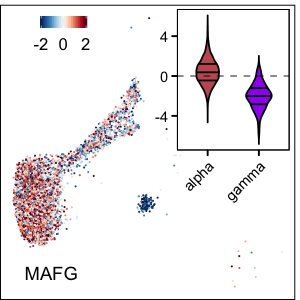

Joining, by = "barcodes"


          UMAP1     UMAP2
[1,] -11.819448 -5.073896
[2,]   8.179459  6.196858


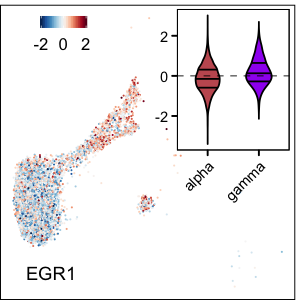

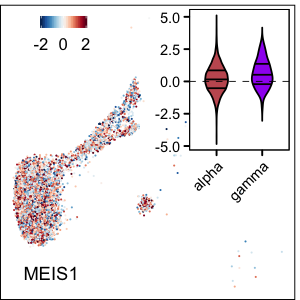

In [71]:
plotMotif_ag <- function(m = "TCF7L2") {
    options(repr.plot.width = 2.5, repr.plot.height = 2.5)
    
    p <- fun.plot.project.motif(motif = m, bks = c(-2, 0, 2), size = 0.25, cls = rev(brewer.pal(n = 11, 
        "RdBu")))
    p$data <- p$data %>% filter(cell_type_overall %in% c("alpha", "gamma"))
    p$data %>% select(UMAP1, UMAP2) %>% apply(2, range) %>% print
    
    p2 <- plotViolin(m, c("alpha", "gamma"))
    
    print(p + annotate(geom = "text", x = -9, y = -4.5, label = m) + annotation_custom((p2 + 
        theme(title = element_blank(), panel.background = element_rect(fill = "white"))) %>% 
        ggplotGrob, -2, 9.5, -2, 7))
    
    ggsave(paste0("~/Dropbox (UCSD_Epigenomics)/workReports/2019-10_islet_rev/Fig1.rev.candid/Fig.1.", 
        m, ".a_g.umap.pdf"), width = 2.5, height = 2.5, units = "in", useDingbats = F)
}
plotMotif_ag("MAFG")
plotMotif_ag("EGR1")
plotMotif_ag("MEIS1")